<hr style="height:2px;">

# Demo: Training data generation for denoising of *Tribolium castaneum*

This notebook demonstrates training data generation for a 3D denoising task, where corresponding pairs of low and high quality stacks can be acquired. 

Each pair should be registered, which is best achieved by acquiring both stacks _interleaved_, i.e. as different channels that correspond to the different exposure/laser settings. 

We will use a single Tribolium stack pair for training data generation, whereas in your application you should aim to acquire at least 10-50 stacks from different developmental timepoints to ensure a well trained model. 

More Documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread

from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches, no_background_patches

In [24]:
'''
download_and_extract_zip_file (
    url       = 'http://csbdeep.bioimagecomputing.com/example_data/tribolium.zip',
    targetdir = 'data',
)

'''

Files found, nothing to download.

data:
- tribolium
- tribolium\test
- tribolium\test\GT
- tribolium\test\GT\nGFP_0.1_0.2_0.5_20_14_late.tif
- tribolium\test\low
- tribolium\test\low\nGFP_0.1_0.2_0.5_20_14_late.tif
- tribolium\train
- tribolium\train\GT
- tribolium\train\GT\nGFP_0.1_0.2_0.5_20_13_late.tif
- tribolium\train\low
- tribolium\train\low\nGFP_0.1_0.2_0.5_20_13_late.tif


We can plot the training stack pair via maximum-projection:

image size = (41, 512, 512)


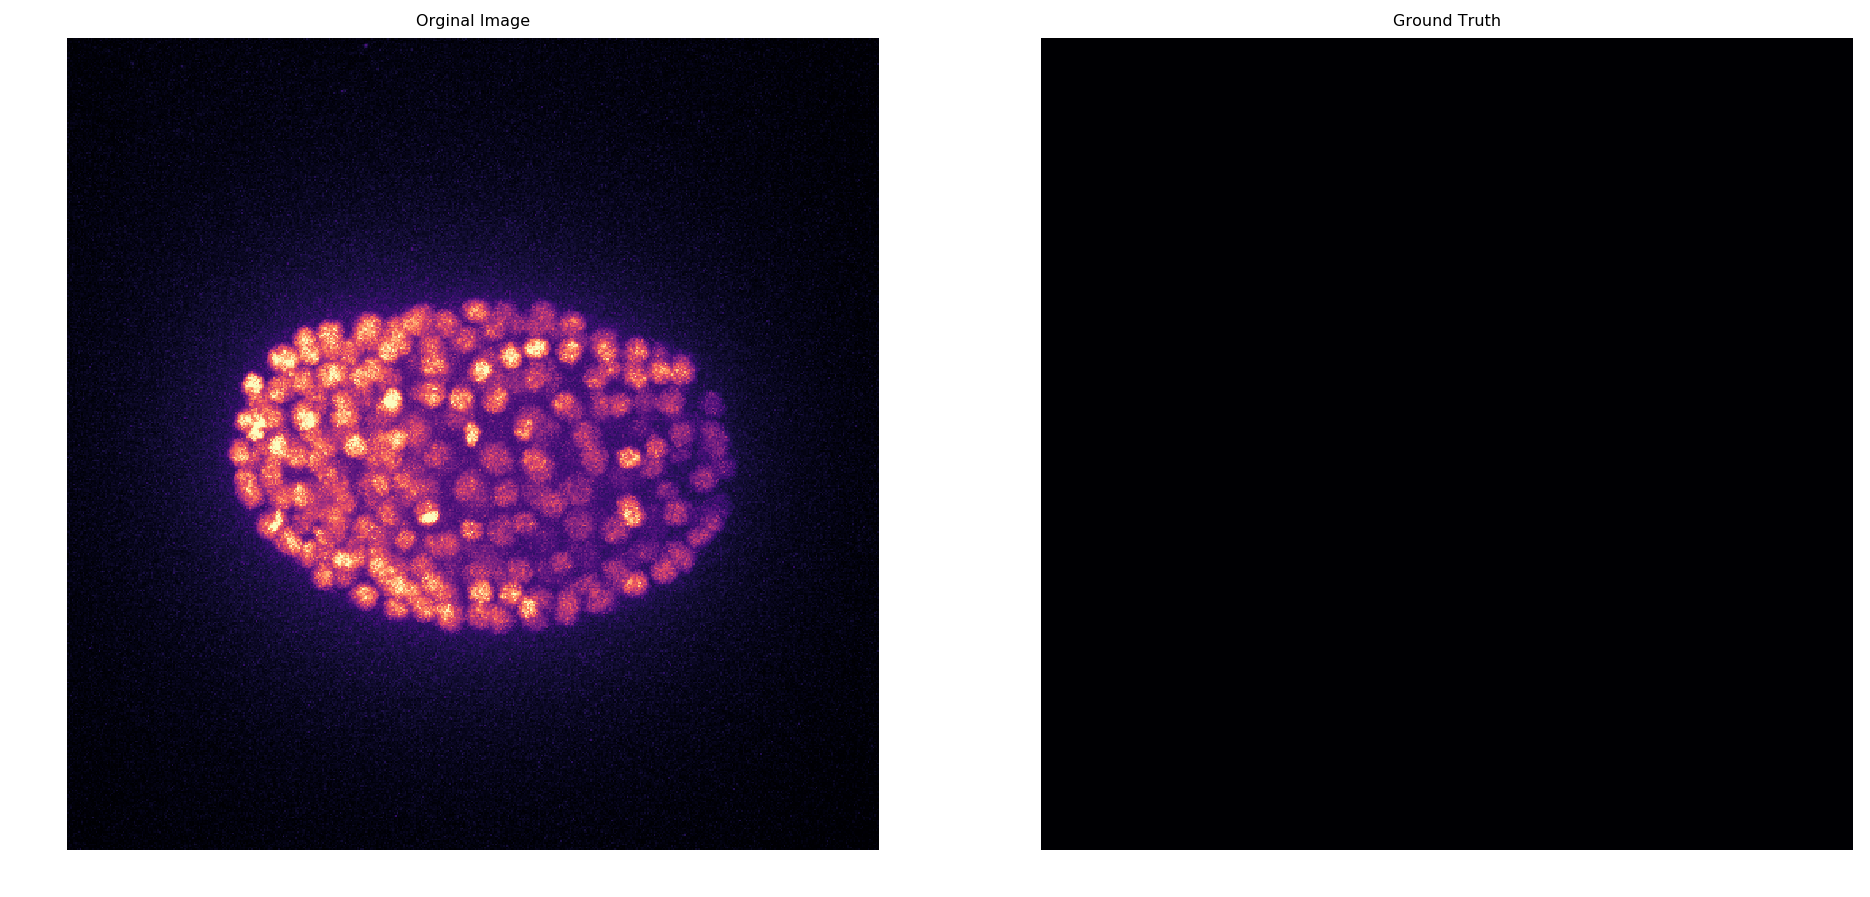

In [3]:
x = imread('L:/kovacevi/Si_obj_trial/20140407_JIM113_SiO60/20140407_JIM113_SiO-0.15_1_s2_t200.TIF')
y = imread('L:/kovacevi/Si_obj_trial/20140407_JIM113_SiO60/ground_truth/20140407_JIM113_SiO-0.15_1_s1_t200.tif')
print('image size =', x.shape)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]),
          title_list=[['Orginal Image','Ground Truth']], 
          pmin=2,pmax=99.8);

<hr style="height:2px;">

# Generate training data for CARE

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR stacks and the semantics of each axis (e.g. which one is considered a color channel, etc.).

Here we have two folders "low" and "GT", where corresponding low and high-SNR stacks are TIFF images with identical filenames.  
For this case, we can simply use `RawData.from_folder` and set `axes = 'ZYX'` to indicate the semantic order of the image axes. 

In [7]:
raw_data = RawData.from_folder (
    basepath    = 'L:/kovacevi/Si_obj_trial/20140407_JIM113_SiO60/newtestData',
    source_dirs = ['X'],
    target_dir  = 'test_ground_truth',    
    
    axes        = 'ZYX',
)

From corresponding stacks, we now generate some 3D patches. As a general rule, use a patch size that is a power of two along XYZT, or at least divisible by 8.  
Typically, you should use more patches the more trainings stacks you have. By default, patches are sampled from non-background regions (i.e. that are above a relative threshold), see the documentation of `create_patches` for details.

Note that returned values `(X, Y, XY_axes)` by `create_patches` are not to be confused with the image axes X and Y.  
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.

In [8]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (8,64,64),
    n_patches_per_image = 10,
    patch_filter = no_background_patches(0.2),
    save_file           = 'newerData1.npz',
)

   71 raw images x    1 transformations   =    71 images
   71 images     x   10 patches per image =   710 patches in total
Input data:
L:/kovacevi/Si_obj_trial/20140407_JIM113_SiO60/newtestData: target='test_ground_truth', sources=['X'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
8 x 64 x 64


100%|██████████| 71/71 [01:29<00:00,  1.27s/it]


Saving data to newerData1.npz.


In [6]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (1170, 1, 16, 64, 64)
axes  of X,Y = SCZYX


## Show

This shows the maximum projection of some of the generated patch pairs (even rows: *input*, odd rows: *target*)

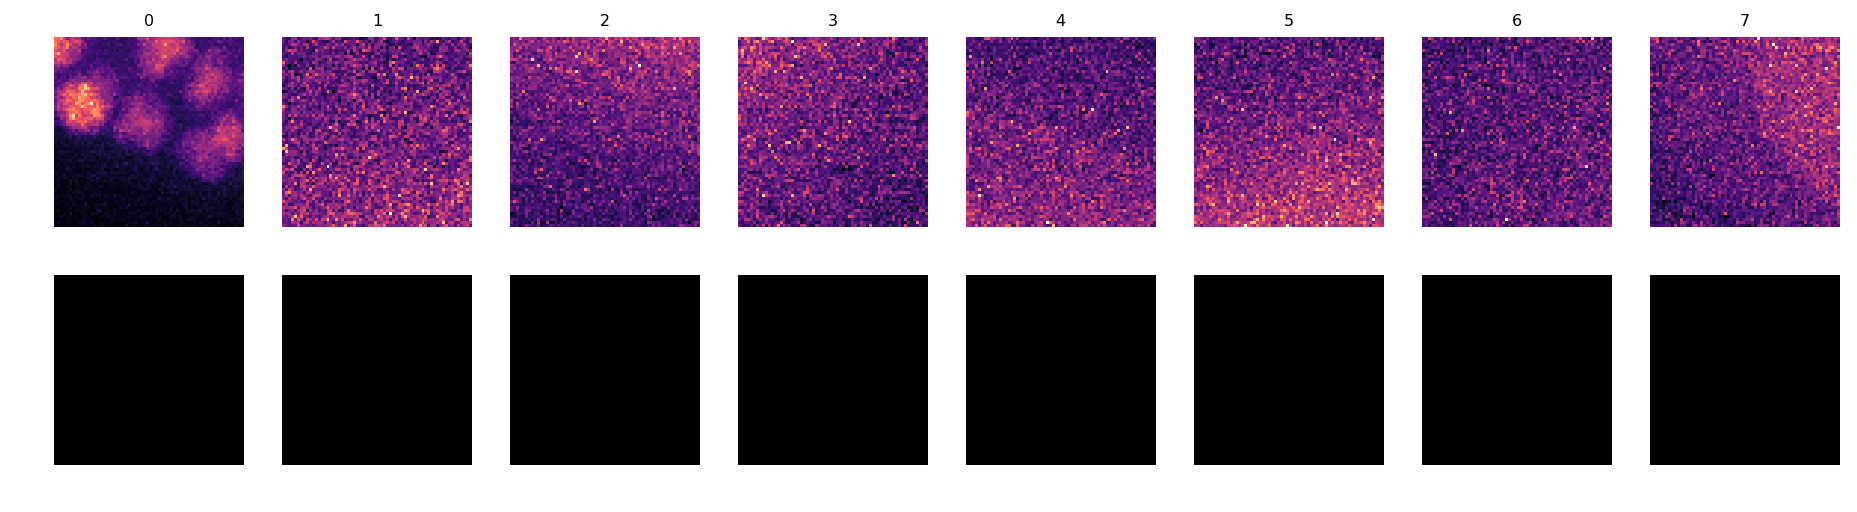

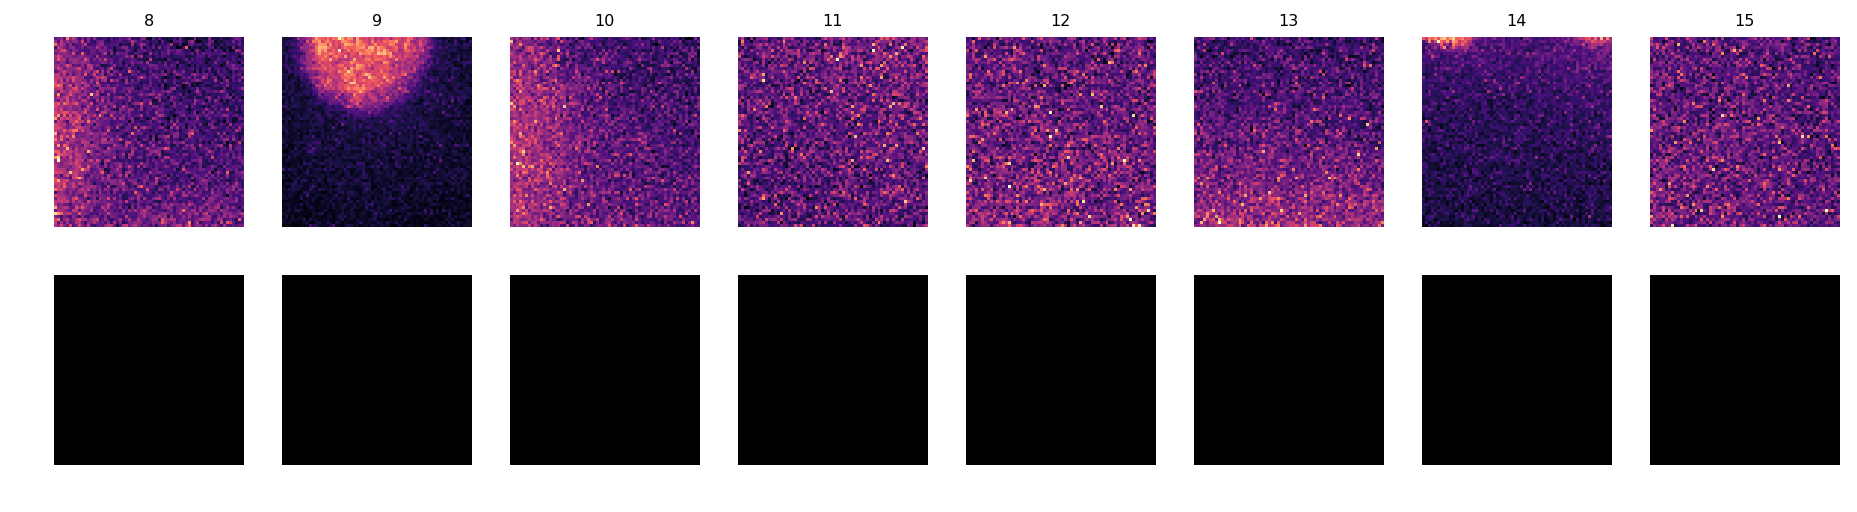

In [7]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;